<a href="https://colab.research.google.com/github/cpyp-ipdp/pgd_cdmx/blob/main/indicadores/pueblos_indigenas/indicadores_pueblos_indigenas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##Estimación de indicadores de población indígena en la Ciudad de México
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr, haven, googledrive, sysfonts, showtext, ggplot2, janitor)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)
Sys.setlocale("LC_ALL", "es_MX.UTF-8")

Cargando paquete requerido: pacman




magrittr (2.0.3 -> 2.0.4) [CRAN]
tibble   (3.2.1 -> 3.3.0) [CRAN]
ggplot2  (3.5.2 -> 4.0.0) [CRAN]


Installing 3 packages: magrittr, tibble, ggplot2

Warning message:
"packages 'tibble', 'ggplot2' are in use and will not be installed"
Installing package into 'C:/Users/JUD de Visualización/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'magrittr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'magrittr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\JUD de Visualización\AppData\Local\R\win-library\4.5\00LOCK\magrittr\libs\x64\magrittr.dll  a C:\Users\JUD de Visualización\AppData\Local\R\win-library\4.5\magrittr\libs\x64\magrittr.dll: Permission denied"
Warning message:
"restored 'magrittr'"



The downloaded binary packages are in
	C:\Users\JUD de Visualización\AppData\Local\Temp\Rtmpwng33R\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────



Please download and install Rtools 4.5 from https://cran.r-project.org/bin/windows/Rtools/.



* checking for file 'C:\Users\JUD de Visualización\AppData\Local\Temp\Rtmpwng33R\remotes22ec3000777c\cpyp-ipdp-funcionespgd-6fd64b9/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/JUD de Visualización/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



[1] "LC_COLLATE=es_MX.UTF-8;LC_CTYPE=es_MX.UTF-8;LC_MONETARY=es_MX.UTF-8;LC_NUMERIC=C;LC_TIME=es_MX.UTF-8"

In [2]:
#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

In [3]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

In [4]:
url_basica<-"https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte<-"microdatos/enigh"
fin1<-"_ns_"
fin2<-"_csv.zip"

In [5]:
years<-c("2016", "2018", "2020", "2022","2024")

In [6]:
# Función genérica para descargar, descomprimir, renombrar y eliminar
procesar_archivo <- function(year, tipo, url_base, segunda_parte, fin1, fin2, carpeta_destino) {
  # Construir URL y ruta de destino
  url <- paste0(url_base, year, "/", segunda_parte, year, fin1, tipo, fin2)
  destfile <- paste0(carpeta_destino, "/", year, fin1, tipo, fin2)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = carpeta_destino)

  # Renombrar el archivo descomprimido
  file.rename(
    from = paste0(carpeta_destino, "/", tipo, ".csv"),
    to = paste0(carpeta_destino, "/", tipo, "_", year, ".csv")
  )

  # Eliminar el archivo descargado
  file.remove(destfile)
}

In [7]:
# Iterar sobre los años y procesar cada tipo de archivo

for (i in 1:length(years)) {
  procesar_archivo(years[i], "poblacion", url_basica, segunda_parte, fin1, fin2, "data")
  procesar_archivo(years[i], "viviendas", url_basica, segunda_parte, fin1, fin2, "data")
  #procesar_archivo(years[i], "trabajos", url_basica, segunda_parte, fin1, fin2, "data")
}

### Función de estimación

In [8]:
estimacion <- function(path, variable) {
  # Cargar los datos de población
  datos <- read_csv(path, show_col_types = FALSE)

  # Si son datos de 2016 a 2020, unir con la tabla de viviendas
  if (substr(path, 16, 19) %in% c("2016", "2018", "2020")) {
    # Cargar tabla viviendas
    vivienda <- read_csv(str_replace(path, "poblacion", "viviendas"), show_col_types = FALSE)

    # Pegar factor, upm y est_dis de la tabla vivienda
    datos <- datos %>%
      left_join(vivienda %>% select(folioviv, factor, upm, est_dis), by = "folioviv")
  }

  # Unir con la tabla trabajos si es "ocupacion" o si la persona debe ser identificada como indígena
  if (variable %in% c("ocupacion", "ocupacion_mujer")) {
    # Cargar tabla trabajos
    trabajos <- read_csv(str_replace(path, "poblacion", "trabajos"), show_col_types = FALSE)

    # Pegar datos relevantes de la tabla trabajos
    datos <- datos %>%
      left_join(trabajos %>% select(folioviv, foliohog, numren, id_trabajo, trapais),
                by = c("folioviv", "foliohog", "numren"))
  }

  # Crear variable cve_ent
  datos <- datos %>%
    mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    )) %>%
    # Filtrar si entidad es CDMX (09)
    filter(cve_ent == "09")

  # Definir diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)



  # Estimar población analfabeta
  if (variable == "analfabetismo") {
    analfa <- mydesign %>%
      group_by(etnia,alfabetism) %>%
      summarise(
        analfabetas = survey_total(vartype = "cv"),
        porcentaje = survey_prop(vartype = "cv")
      ) %>%
      mutate(porcentaje = round(porcentaje * 100, 2)) %>%
      # Añadir año
      mutate(year = substr(path, 16, 19)) %>%
filter(etnia == 1)%>%
filter(alfabetism == 2)
    return(analfa)
  }

}


####   Población analfabeta indígena en CDMX

In [9]:
tabla_analfabetismo<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "poblacion_.*.csv"),
  estimacion,
  variable = "analfabetismo"
)
print("Población que se autodescribe como indígena y que es analfabeta en la CDMX")

tabla_analfabetismo

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"There was 1 warning in `dplyr::summarise()`.
ℹ In argument: `porcentaje = survey_prop(vartype = "cv")`.
ℹ In group 5: `etnia = NA` `alfabetism = NA`.
Caused by warning:
! glm.fit: algorithm did not converge"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Warning message:
"There was 1 warning in `dplyr::summarise()`.
ℹ In argument: `porcentaje = survey_prop(vartype = "cv")`.
ℹ In group 5: `etnia = NA` `alfabetism = NA`.
Caused by warning:
! glm.fit: algorithm did not co

[1] "Población que se autodescribe como indígena y que es analfabeta en la CDMX"


etnia,alfabetism,analfabetas,analfabetas_cv,porcentaje,porcentaje_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,2,76848,0.2047636,6.14,0.1804278,2016
1,2,100372,0.1583444,7.33,0.1251706,2018
1,2,91929,0.1348095,6.60,0.1153417,2020
1,2,63920,0.2065419,5.79,0.1828260,2022
1,2,43615,0.2436306,5.82,0.2287045,2024


### Estimación de metas de indicadores propuestos

*Porcentaje de población analfabeta indígena en la CDMX*

In [10]:
#Tabla de analfabetismo
datos<-data.frame(tabla_analfabetismo$year,tabla_analfabetismo$porcentaje)%>%
    rename(year=tabla_analfabetismo.year,
             porcentaje=tabla_analfabetismo.porcentaje)%>%
mutate(year=as.numeric(year))
datos

year,porcentaje
<dbl>,<dbl>
2016,6.14
2018,7.33
2020,6.60
2022,5.79
2024,5.82


In [11]:
##Calcular tasa de crecimiento promedio anual de 2016 a 2022

valor_inicial<-datos$porcentaje[1]
valor_final <- datos$porcentaje[length(datos$porcentaje)]
n <- datos$year[length(datos$year)] - datos$year[1]

tasa_crecimiento <- (valor_final / valor_inicial)^(1 / n) - 1
print("Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025")
tasa_crecimiento

[1] "Se estima una tasa de crecimiento promedio anual para utilizarse como base en la proyección de metas a 2025"


[1] -0.006668228

In [12]:
proyecciones <- data.frame(year = seq(2025, 2045, by = 1))
proyecciones$porcentaje <- valor_final * (1 + tasa_crecimiento)^(proyecciones$year - 2022)
proyecciones

year,porcentaje
<dbl>,<dbl>
2025,5.704347
2026,5.666309
2027,5.628525
2028,5.590993
2029,5.553711
2030,5.516678
2031,5.479891
2032,5.443350
2033,5.407052


#### Gráfica con nuevo formato 

In [51]:
# Dataframe de ejemplo CORREGIDO - VERSIÓN BIENAL
set.seed(123)

# 🔹 Secuencia bienal de 2016 a 2045
ciclos <- seq(2016, 2046, by = 2)  # termina en 2044 para mantener paridad

df_final <- data.frame(
  ciclo = ciclos,
  
  # Observado hasta 2024 (histórico)
  Deseable = c(
    6.14, 7.33, 6.60, 5.79, 5.82,  # 2016–2024 (5 valores observados)
    seq(5.82, 4.99, length.out = length(ciclos) - 5)  # proyección 2026–2045
  ),
  
  # Inercial: el MENOR
  Inercial = c(
    rep(NA, 5),  # No existe antes de 2024
    seq(5.82, 4.59, length.out = length(ciclos) - 5)
  ),
  
  # Transformador: el MAYOR
  Transformador = c(
    rep(NA, 5),
    seq(5.82, 5.43, length.out = length(ciclos) - 5)
  )
)

# 🔹 Asegurar que 2024 sea el mismo valor en los tres escenarios
df_final$Deseable[df_final$ciclo == 2024] <- 5.82
df_final$Inercial[df_final$ciclo == 2024] <- 5.82
df_final$Transformador[df_final$ciclo == 2024] <- 5.82

# 🔹 Redondear a 2 decimales
df_final[, -1] <- round(df_final[, -1], 2)

# 🔹 Ver resultado
df_final


ciclo,Deseable,Inercial,Transformador
<dbl>,<dbl>,<dbl>,<dbl>
2016,6.14,NA,NA
2018,7.33,NA,NA
2020,6.60,NA,NA
2022,5.79,NA,NA
2024,5.82,5.82,5.82
2026,5.82,5.82,5.82
2028,5.74,5.70,5.78
2030,5.65,5.57,5.74
2032,5.57,5.45,5.70


In [52]:
#Parámetros

#Año base
ano_base <- 2024

#Agregar fuente Roboto
font_add_google('Roboto', 'roboto')
showtext_auto()

#Tema para el gráfico
theme_set(theme_minimal(base_family = 'roboto', base_size = 10))
theme_update(
  axis.title = element_text(size = 12),
  plot.title = element_text(size = 14, hjust = 0.5, face = 'bold'),
  axis.text = element_text(size = 10),
  legend.text = element_text(size = 10),
  legend.title = element_text(size = 12))

In [53]:
df_final$ciclo[df_final$ciclo == 2046] <- 2045
df_final

ciclo,Deseable,Inercial,Transformador
<dbl>,<dbl>,<dbl>,<dbl>
2016,6.14,NA,NA
2018,7.33,NA,NA
2020,6.60,NA,NA
2022,5.79,NA,NA
2024,5.82,5.82,5.82
2026,5.82,5.82,5.82
2028,5.74,5.70,5.78
2030,5.65,5.57,5.74
2032,5.57,5.45,5.70


In [54]:
#El dataframe debe contener las columnas: ciclo, Deseable, Inercial, Transformador

obs <- df_final %>% #observado
filter(ciclo <= ano_base)

fut <- df_final %>% #escenarios futuros
filter(ciclo >= ano_base)

Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_line()`)."


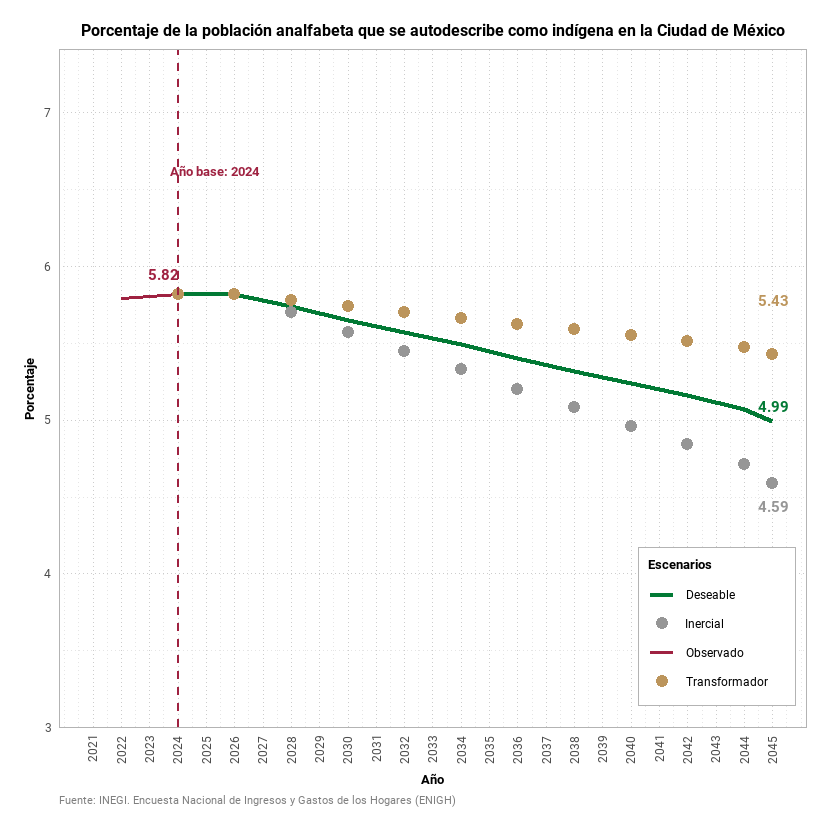

In [68]:
p <- ggplot() +
  
  # === Observado ===
  geom_line(data = obs, aes(x = ciclo, y = Deseable, color = "Observado"), linewidth = 1.1) +
  
  # === Deseable ===
  geom_line(data = fut, aes(x = ciclo, y = Deseable, color = "Deseable"), linewidth = 1.25) +
  
  # === Escenarios futuros ===
  geom_point(data = fut, aes(x = ciclo, y = Inercial, color = "Inercial"), size = 3) +
  geom_point(data = fut, aes(x = ciclo, y = Transformador, color = "Transformador"), size = 3) +
  
  # === Línea vertical del año base ===
  geom_vline(xintercept = ano_base, color = "#9F2241", linetype = "dashed", linewidth = 0.7) +
  
  # === Texto "Año base: 2024" (ahora ARRIBA del punto) ===
  annotate("text",
           x = ano_base + 1.3,        
           y = df_final$Deseable[df_final$ciclo == ano_base] + 0.80,  # 👈 lo subimos
           label = paste("Año base:", ano_base),
           color = "#9F2241", size = 3.5, family = "roboto", fontface = "bold") +
  
  # === Valor del año base (debajo del texto) ===
  annotate("text", 
           x = ano_base - 0.5,   
           y = df_final$Deseable[df_final$ciclo == ano_base] + 0.13,  # 👈 un poco arriba del punto
           label = sprintf("%.2f", df_final$Deseable[df_final$ciclo == ano_base]),
           color = "#9F2241", size = 4, fontface = "bold", family = "roboto") +
  
  # === Etiquetas finales (2045) ===
  annotate("text", x = 2045, y = df_final$Deseable[df_final$ciclo == 2045] + 0.1,
           label = sprintf("%.2f", df_final$Deseable[df_final$ciclo == 2045]),
           color = "#027a35", size = 4, fontface = "bold", family = "roboto") +
  
  annotate("text", x = 2045, y = df_final$Inercial[df_final$ciclo == 2045] - 0.15,
           label = sprintf("%.2f", df_final$Inercial[df_final$ciclo == 2045]),
           color = "#969696", size = 4, fontface = "bold", family = "roboto") +
  
  annotate("text", x = 2045, y = df_final$Transformador[df_final$ciclo == 2045] + 0.35,
           label = sprintf("%.2f", df_final$Transformador[df_final$ciclo == 2045]),
           color = "#BC955C", size = 4, fontface = "bold", family = "roboto") +
  
  # === Títulos y ejes ===
  labs(
    title = "Porcentaje de la población analfabeta que se autodescribe como indígena en la Ciudad de México",
    x = "Año",
    y = "Porcentaje",
    color = "Escenarios",
    caption = "Fuente: INEGI. Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH)"
  ) +
  
  # === Escalas ===
  scale_y_continuous(limits = c(3, 7.2), expand = expansion(mult = c(0, 0.05))) +
  scale_x_continuous(breaks = seq(2021, 2045, 1), limits = c(2021, 2045)) +
  
  # === Colores ===
  scale_color_manual(values = c(
    "Observado" = "#9F2241",
    "Deseable" = "#027a35",
    "Inercial" = "#969696",
    "Transformador" = "#BC955C"
  )) +
  
  # === Tema y leyenda más abajo ===
  theme_minimal(base_family = "roboto") +
  theme(
    plot.title = element_text(face = "bold", size = 12, hjust = 0.5),
    axis.title = element_text(size = 10, face = "bold"),
    axis.text = element_text(size = 9),
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1),
    panel.grid.major = element_line(color = "gray80", linetype = "dotted", linewidth = 0.5),
    panel.grid.minor = element_line(color = "gray90", linetype = "dotted", linewidth = 0.3),
    plot.caption = element_text(hjust = 0, size = 8, color = "gray50"),
    legend.title = element_text(face = "bold", size = 10),
    legend.text = element_text(size = 9),
    legend.position = c(0.88, 0.15),
    legend.background = element_rect(fill = "white", color = "gray70", size = 0.3),
    legend.key = element_rect(fill = "white", color = NA),
    panel.border = element_rect(color = "gray70", fill = NA, linewidth = 0.5),
    plot.margin = margin(15, 20, 20, 15)
  )

print(p)
